In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-11-02 23:45:46.253597: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 23:45:47.054111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 128
learning_rate = 1e-3
batch_per_file_size = 8
node_embedding_size = 12
layers = [128, 64, 32, 32]

dataset = LayoutDataset(
    batch_size, train_sample_fraction=1.0,
    subset=None, build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-11-02 23:45:48.604724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 23:45:48.701217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 23:45:48.701559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    mask_max_len=dataset.n_config_nodes_upper_limit,
    batch_per_file_size=batch_per_file_size,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=5,
    layer_sizes=layers,
    loss='pairwise_hinge',
    l1_multiplier=1e-8,
    n_siblings=dataset.n_siblings
)

In [4]:
mlp.train(dataset, None)

2023-11-02 23:49:12.291742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-02 23:49:12.329970: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff029d7c690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-02 23:49:12.329994: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-11-02 23:49:12.374854: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-02 23:49:12.628940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-02 23:49:12.832554: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

iteration 500 training loss 3.4219928 lr 0.00005
iteration 1000 training loss 3.2347896 lr 0.00010
iteration 1500 training loss 3.2432592 lr 0.00015
iteration 2000 training loss 2.6947565 lr 0.00020
iteration 2500 training loss 2.733272 lr 0.00025
iteration 3000 training loss 2.8103275 lr 0.00030
iteration 3500 training loss 2.6778295 lr 0.00035
iteration 4000 training loss 2.49774 lr 0.00040
iteration 4500 training loss 2.2026868 lr 0.00045
iteration 5000 training loss 1.7895927 lr 0.00050
iteration 5500 training loss 1.7111102 lr 0.00055
iteration 6000 training loss 2.4771273 lr 0.00060
iteration 6500 training loss 1.9413738 lr 0.00065
iteration 7000 training loss 1.6496222 lr 0.00070
iteration 7500 training loss 2.2681804 lr 0.00075
iteration 8000 training loss 2.5232797 lr 0.00080
iteration 8500 training loss 2.1871772 lr 0.00085
iteration 9000 training loss 1.7784923 lr 0.00090
iteration 9500 training loss 1.8607097 lr 0.00095
iteration 10000 training loss 1.8388703 lr 0.00100
lay

iteration 70000 training loss 1.052112 lr 0.00087
layout:nlp:random 0.898543931464425
layout:nlp:default 0.4744446610849321
layout:xla:random 0.6450530033092299
layout:xla:default 0.2669444678695569
epoch 0, it 70000 validation loss -0.571
iteration 70500 training loss 1.1692464 lr 0.00086
iteration 71000 training loss 1.2075753 lr 0.00086
iteration 71500 training loss 0.77724504 lr 0.00086
iteration 72000 training loss 1.4016438 lr 0.00086
iteration 72500 training loss 1.0562782 lr 0.00086
iteration 73000 training loss 0.9976569 lr 0.00085
iteration 73500 training loss 0.7628173 lr 0.00085
iteration 74000 training loss 1.2824947 lr 0.00085
iteration 74500 training loss 0.82390314 lr 0.00085
iteration 75000 training loss 1.100971 lr 0.00084
iteration 75500 training loss 1.2134871 lr 0.00084
iteration 76000 training loss 1.1107612 lr 0.00084
iteration 76500 training loss 0.9933494 lr 0.00084
iteration 77000 training loss 1.0989168 lr 0.00083
iteration 77500 training loss 0.863891 lr 0.0

iteration 136500 training loss 1.0562551 lr 0.00050
iteration 137000 training loss 0.7356348 lr 0.00049
iteration 137500 training loss 0.5532014 lr 0.00049
iteration 138000 training loss 1.5259392 lr 0.00049
iteration 138500 training loss 0.8165723 lr 0.00048
iteration 139000 training loss 1.4034979 lr 0.00048
iteration 139500 training loss 0.9766419 lr 0.00048
iteration 140000 training loss 0.9563657 lr 0.00047
layout:nlp:random 0.9251620639296212
layout:nlp:default 0.49849566102888687
layout:xla:random 0.6710316773592157
layout:xla:default 0.26338495526693195
epoch 0, it 140000 validation loss -0.590
iteration 140500 training loss 1.3759949 lr 0.00047
iteration 141000 training loss 0.85228336 lr 0.00047
iteration 141500 training loss 0.9699231 lr 0.00046
iteration 142000 training loss 1.3486896 lr 0.00046
iteration 142500 training loss 0.81262106 lr 0.00046
iteration 143000 training loss 1.1757568 lr 0.00046
iteration 143500 training loss 1.0677707 lr 0.00045
iteration 144000 trainin

iteration 202500 training loss 1.3132144 lr 0.00013
iteration 203000 training loss 1.0450685 lr 0.00013
iteration 203500 training loss 1.3053786 lr 0.00013
iteration 204000 training loss 1.6087761 lr 0.00013
iteration 204500 training loss 1.00989 lr 0.00013
iteration 205000 training loss 1.2187762 lr 0.00012
iteration 205500 training loss 1.4363816 lr 0.00012
iteration 206000 training loss 1.0418191 lr 0.00012
iteration 206500 training loss 1.0061948 lr 0.00012
iteration 207000 training loss 0.9108262 lr 0.00012
iteration 207500 training loss 1.2854452 lr 0.00011
iteration 208000 training loss 0.84809315 lr 0.00011
iteration 208500 training loss 1.2886319 lr 0.00011
iteration 209000 training loss 1.2937577 lr 0.00011
iteration 209500 training loss 1.1110744 lr 0.00011
iteration 210000 training loss 0.941463 lr 0.00010
layout:nlp:random 0.9332776149663824
layout:nlp:default 0.5070958158156685
layout:xla:random 0.6769490205370007
layout:xla:default 0.2836818347212653
epoch 0, it 210000 v

## Evaluate validation set

In [5]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

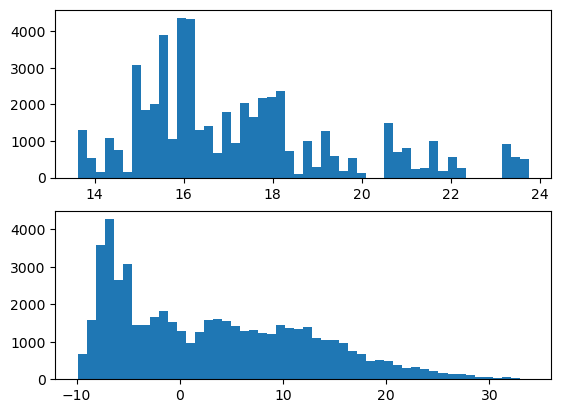

In [6]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [7]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train',b'layout:nlp:default:bert_multi_cased_L-12_H-7...,46,-9.893137,17.403856
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-768_A-12_batch_size_16_train',b'layout:nlp:default:small_bert_bert_en_uncase...,61,-9.738308,17.053982
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train',b'layout:nlp:default:small_bert_bert_en_uncase...,206,-9.734893,15.862122
b'layout:nlp:default:small_bert_bert_en_uncased_L-12_H-768_A-12_batch_size_64_train',b'layout:nlp:default:small_bert_bert_en_uncase...,10,-9.120729,18.141766
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-768_A-12_batch_size_32_train',b'layout:nlp:default:small_bert_bert_en_uncase...,96,-8.755333,17.015160
b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train',b'layout:nlp:default:small_bert_bert_en_uncase...,9,-8.725102,15.192575
b'layout:nlp:default:talking-heads_large_batch_size_16_train',b'layout:nlp:default:talking-heads_large_batch...,1,-8.473538,18.689413
b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-512_A-8_batch_size_32_train',b'layout:nlp:default:small_bert_bert_en_uncase...,16,-8.261893,16.100836
b'layout:nlp:default:albert_en_xlarge_batch_size_16_test',b'layout:nlp:default:albert_en_xlarge_batch_si...,148,-8.075919,17.862574


Text(0.5, 1.0, "b'layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test'")

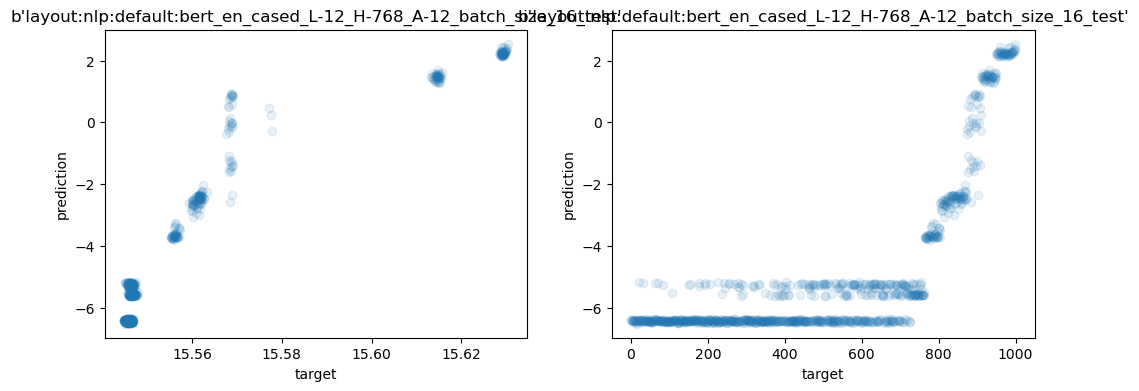

In [10]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
#graph_id = b'layout:xla:default:unet_3d.4x4.bf16'
random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

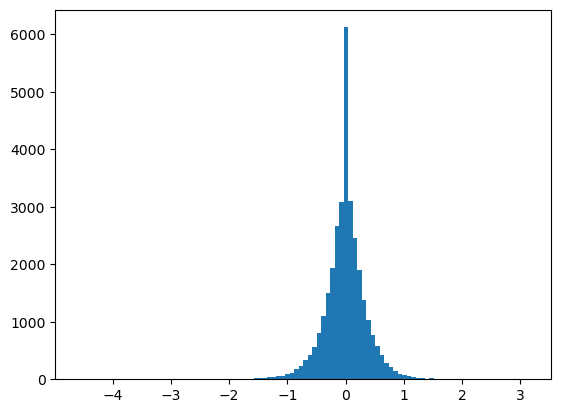

In [21]:
plt.hist(mlp.dense_layer_node_1.kernel.numpy().flatten(), bins=100);

In [ ]:
plt.figure(figsize=(14, 4))
kind = 1
plt.subplot(2, 1, 1)
k_vals = mlp.k_layer.kernel.numpy().reshape(203, 12, -1)[:, kind, :].T
plt.imshow(k_vals)

plt.subplot(2, 1, 2)
q_vals = mlp.q_layer.kernel.numpy().reshape(203, 12, -1)[:, kind, :].T
plt.imshow(q_vals)

00        interesting features (20)
            np.arange(21, 27),  # shape dims
            np.arange(31, 37),  # reshape/broadcast dims
            np.arange(95, 99),  # conv dims input
            np.arange(101, 105),  # conv dims kernel
20        parent output shapes (12)
32        sibling shapes (n_siblings*6)
50        physical layout (6)
56        node layout (18)
74        parent phys layout (12)
86        siblings layout (n_sibling*18)
140        parent opcodes (2)
164        sibling opcodes (n_siblings)
200        opcode (1)

In [ ]:
lens = [20, 12, 18, 6, 18, 12, 18*3, 24, 36, 12]
np.cumsum(lens)

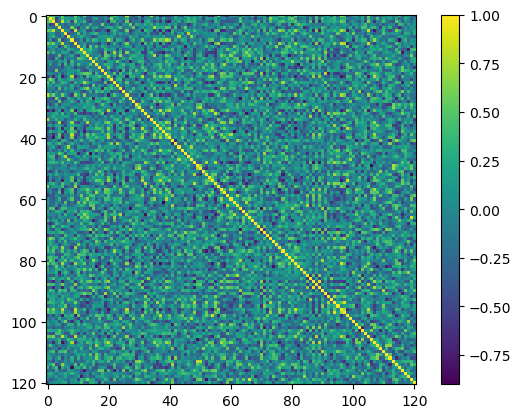

In [11]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [ ]:
dots[34, 26]

In [ ]:
np.argsort(dots[26])

In [ ]:
ind = np.unravel_index(np.argsort(dots.flatten())[-122], dots.shape)
ind

In [ ]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
layout_ids = val_batch['layout_id']
config_descriptor = val_batch['node_descriptor']
valid_mask = val_batch['valid_nodes']
graph_descriptor = val_batch['graph_descriptor']

with tf.device('/cpu:0'):
    subset_info_str = tf.map_fn(
        lambda layout_id: tf.strings.reduce_join(
            tf.strings.split(layout_id, ":")[:3]),
        layout_ids
    )

subset_info = mlp.text_vectorization(subset_info_str)
subset_info = tf.expand_dims(subset_info, axis=-1)
subset_info = mlp.embedding_layer_subset_info(subset_info)
subset_info = subset_info[:, 0, :]

# for si, sn in zip(subset_info_str.numpy(), subset_info.numpy()):
#     print(si, sn)

node_operations = config_descriptor[:, :, -1]
config_descriptor = config_descriptor[:, :, :-1]
node_operations = tf.cast(node_operations, tf.int32)
# node_operations.shape == (batch_size, mask_max_len)                                                                                                                                 
node_embedding = mlp.embedding_layer_node_ops(node_operations)
# node_embedding.shape == (batch_size, mask_max_len, embed_len)
# np.unique(node_operations.numpy().flatten(), return_counts=True)

x = mlp.normalization_layer_config_nodes(config_descriptor)
normal_graph_descriptor = mlp.normalization_layer_graph_descriptor(graph_descriptor)
x = tf.concat([x, node_embedding], axis=-1)

x = mlp.dense_layer_node_1(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           
x = mlp.dense_layer_node_2(x)
x = mlp.relu_layer(x)  # (batch_size, n_config_nodes_upper_limit, n_units)                                                                                                           

# plt.hist(x.numpy().flatten(), bins=100);
float_mask = tf.sequence_mask(valid_mask, mlp.mask_max_len, dtype=tf.float32)
# (batch_size, n_config_nodes_upper_limit)                                                                                                                                            

float_mask = tf.expand_dims(float_mask, axis=-1)
x = x * float_mask

x = tf.reduce_sum(x, axis=1)
#plt.subplot(2, 1, 1)
#plt.hist(x.numpy().flatten(), bins=100);

x = x / tf.expand_dims(tf.cast(valid_mask, tf.float32), axis=-1)
#plt.subplot(2, 1, 2)
#plt.hist(x.numpy().flatten(), bins=100);
for i, lid, gd, nd in zip(range(96), layout_ids.numpy(), graph_descriptor.numpy(), normal_graph_descriptor.numpy()):
    if i in [19]:
        print(i, gd[80:90], nd[80:90], lid)
x = tf.concat([x, normal_graph_descriptor, subset_info], axis=-1)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_1(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_2(x)
x = mlp.relu_layer(x)
#plt.hist(x.numpy().flatten(), bins=100);
x = mlp.dense_layer_global_3(x)
x = tf.reshape(x, (-1,))
x

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [12]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:nlp:default:albert_en_xlarge_batch_size_16_test                               40722;52387;685;8477;26726;31335;7186;33760;34...
layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test                  1534;34997;34962;21318;1299;51775;82134;86712;...
layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train              22755;22875;8004;8045;22896;8006;3730;13015;22...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test      49125;34468;8879;64897;31789;30090;34286;34446...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train     40701;13398;9242;13422;13372;21188;47388;41900...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test      59153;56548;70724;59186;7560;50866;4951;50879;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train     1050;1093;1292;1036;26775;38379;31270;1199;515...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H

In [13]:
val_df

,ID,config_index,prediction,target
0,b'layout:nlp:random:small_bert_bert_en_uncased...,7315,-0.125398,14.910279
1,b'layout:xla:default:resnet50.4x4.fp16',3433,0.622082,19.361380
2,b'layout:nlp:random:small_bert_bert_en_uncased...,56321,12.528124,15.036487
3,b'layout:nlp:random:small_bert_bert_en_uncased...,37533,20.645527,15.124042
4,b'layout:nlp:random:small_bert_bert_en_uncased...,57875,-2.448342,14.884189
...,...,...,...,...
53476,b'layout:nlp:random:small_bert_bert_en_uncased...,96611,6.322400,14.577062
53477,b'layout:nlp:random:small_bert_bert_en_uncased...,11604,10.771336,14.648499
53478,b'layout:nlp:random:small_bert_bert_en_uncased...,77802,0.434012,14.459706
53479,b'layout:nlp:random:small_bert_bert_en_uncased...,18489,2.643659,14.512586


In [14]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

array(['layout:nlp:random', 'layout:xla:default', 'layout:xla:random',
       'layout:nlp:default'], dtype=object)

In [15]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    print(subset, mean)

layout:nlp:random 0.9332776149663824
layout:xla:default 0.2836818347212653
layout:xla:random 0.6769490205370007
layout:nlp:default 0.5070958158156685


In [16]:
np.mean([0.4185, 0.8167, 0.538, 0.2525])

0.506425

In [17]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

ID
b'layout:xla:default:unet_3d.4x4.bf16'                                                  0.056499
b'layout:xla:default:mlperf_bert_batch_24_2x2'                                          0.108074
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16'                              0.209617
b'layout:xla:random:unet_3d.4x4.bf16'                                                   0.295245
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size'                              0.317092
b'layout:xla:default:inception_v3_batch_128_train'                                      0.329137
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-512_A-8_batch_size_64_test'      0.416624
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train'     0.424638
b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-512_A-8_batch_size_32_train'      0.427788
b'layout:xla:default:bert_pretraining.4x4.fp16'                                         0.454630
b'layout:nlp:default:small_

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [18]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

,ID,config_index,prediction
0,b'layout:nlp:default:492c7a94d559aa4a88769142d...,1,-2.595999
1,b'layout:nlp:default:492c7a94d559aa4a88769142d...,4,-9.057251
2,b'layout:nlp:default:492c7a94d559aa4a88769142d...,20,-8.813255
3,b'layout:nlp:default:492c7a94d559aa4a88769142d...,0,-8.674389
4,b'layout:nlp:default:492c7a94d559aa4a88769142d...,14,-8.626400
...,...,...,...
49997,b'layout:nlp:default:23559853d9702baaaacbb0c83...,993,-6.060427
49998,b'layout:nlp:default:23559853d9702baaaacbb0c83...,998,-4.308775
49999,b'layout:nlp:default:23559853d9702baaaacbb0c83...,978,-4.654196
50000,b'layout:nlp:default:23559853d9702baaaacbb0c83...,989,-4.737990


In [19]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

ID
layout:nlp:default:016ac66a44a906a695afd2228509046a    588;455;233;825;143;294;540;567;843;903;609;91...
layout:nlp:default:171b0513d8874a427ccfa46d136fbadc    682;556;359;486;145;321;919;298;865;939;113;18...
layout:nlp:default:23559853d9702baaaacbb0c83fd32266    297;493;660;6;284;330;737;254;993;827;779;138;...
layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9    314;286;34;974;32;893;705;196;596;204;493;191;...
layout:nlp:default:32531d07a084b319dce484f53a4cf3fc    678;630;371;220;895;638;259;737;162;543;434;81...
layout:nlp:default:38524e2ff135ded55b5286407e7af6b7    84;381;530;997;127;139;927;992;669;206;497;604...
layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba    348;580;812;781;96;174;109;829;900;435;257;237...
layout:nlp:default:492c7a94d559aa4a88769142d2a68362    4;483;295;943;726;571;108;656;907;169;981;778;...
layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad    555;565;239;90;613;996;79;991;159;310;869;954;...
layout:nlp:default:60880ed76de53f4d7a1b960b24f20f7d 

In [20]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('predictions/layout_none_test_prediction_11_03_08_10.csv')